In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image, ImageOps
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
%cd ..

C:\Users\Govert\Documents\VG_covers


In [3]:
# create function to load in images

%config InlineBackend.figure_format= 'retina' 

def load_image_from_path(image_path, target_size = None, color_mode = 'rgb'):
    pil_image = image.load_img(image_path, target_size=target_size,
                            color_mode=color_mode)
    return image.img_to_array(pil_image)

In [4]:
# initialize face detection model
face_classification = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [5]:
# create function to detect faces

def face_detect(image_path):
    results = {}
    
    # face recognition
    pre_image = load_image_from_path(image_path, color_mode='grayscale')
    gray_image = np.squeeze(pre_image).astype('uint8')

    faces = face_classification.detectMultiScale(gray_image, 1.02, 15) # detect the faces 
    n_faces = len(faces) # get the number of faces
    
    return n_faces > 0

In [6]:
# folder with clear face images
face_dir = 'data/clear_faces/'
face_paths = os.listdir(face_dir)

In [7]:
# apply the face detection on all pictures with clear faces
contains_face = []

for p in face_paths:
    res = face_detect(face_dir + p)
    contains_face.append(res)

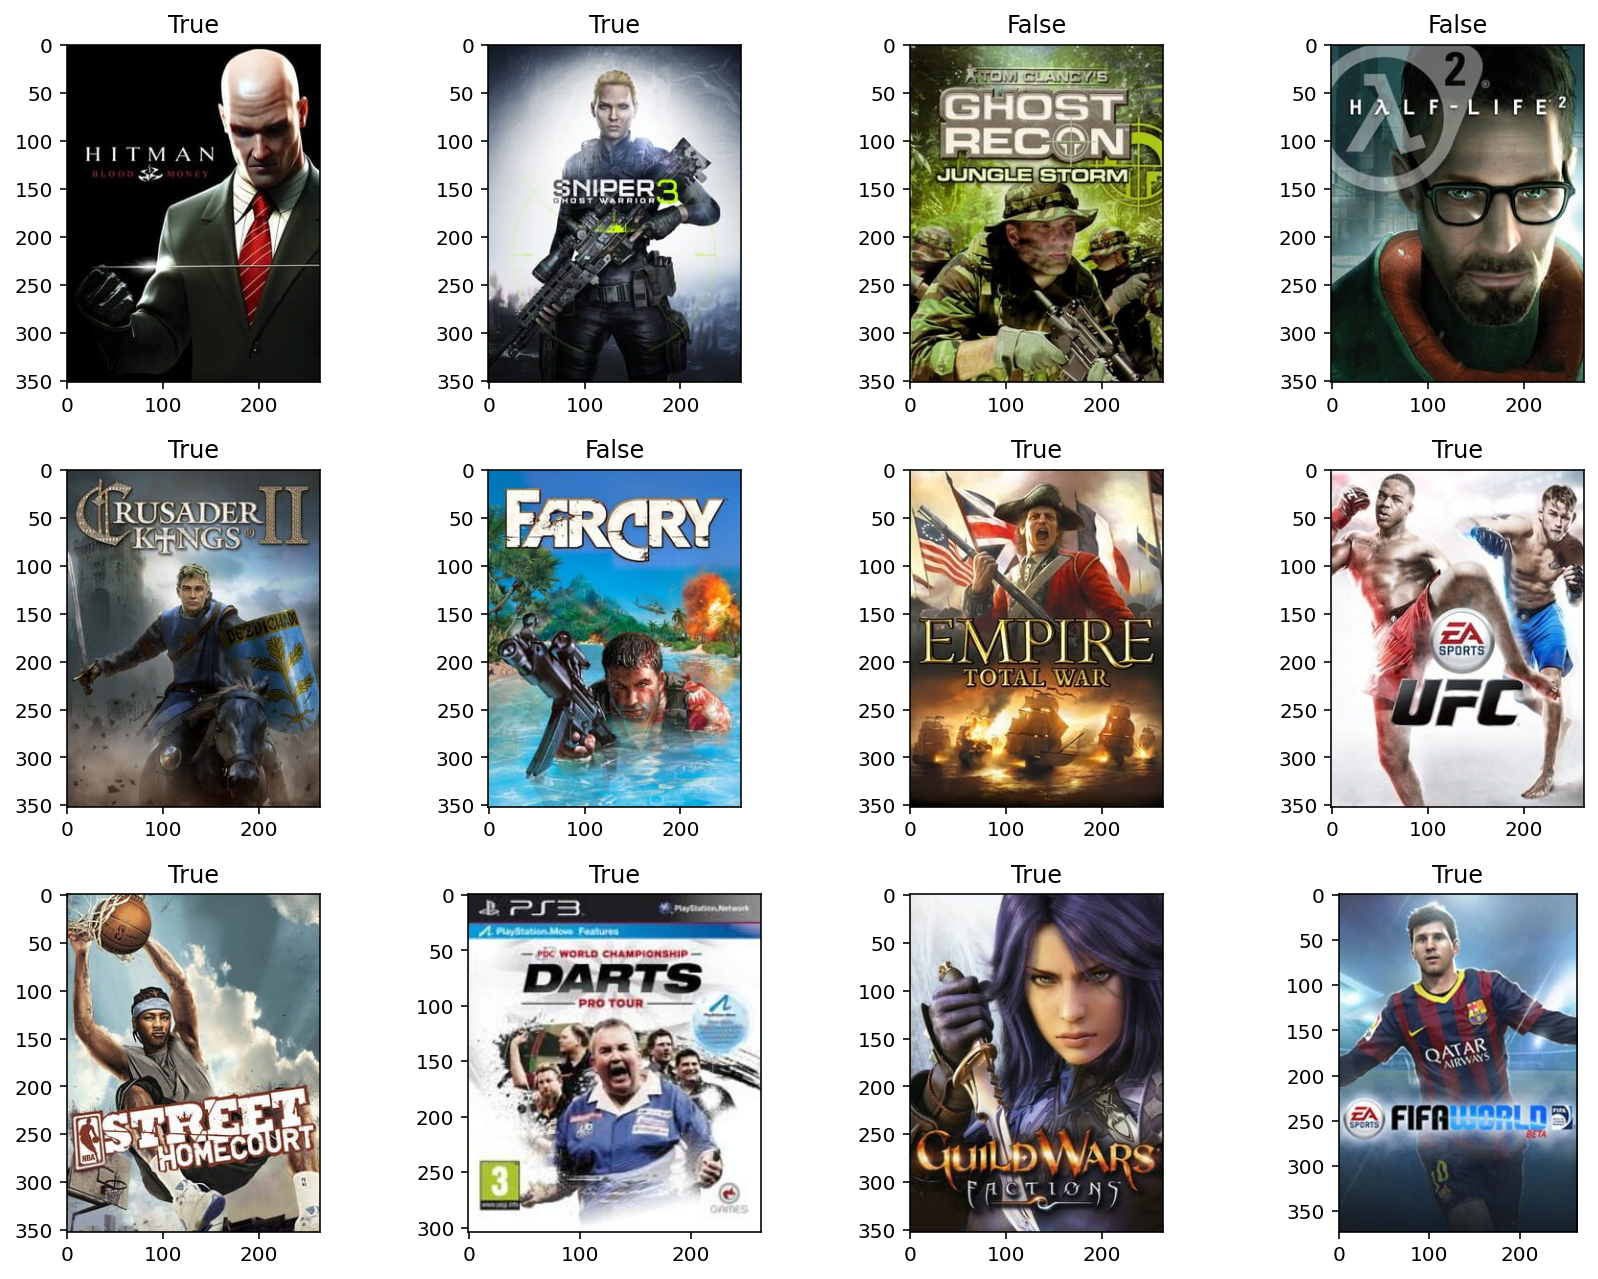

In [8]:
# review results manually
fig, axes = plt.subplots(nrows = 3, ncols= 4 , figsize = (12, 9))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(mpimg.imread(face_dir + face_paths[i]))
    ax.set_title(str(contains_face[i]))
plt.tight_layout()

In [9]:
# folder with all images
im_dir = 'data/covers/'
paths = os.listdir(im_dir)

In [10]:
contains_face = []

for p in paths:
    res = face_detect(im_dir + p)
    contains_face.append(res)

In [11]:
face_df = pd.DataFrame(zip(paths, contains_face))
face_df.columns = ['path', 'face']

In [12]:
sample = face_df.sample(frac=1)

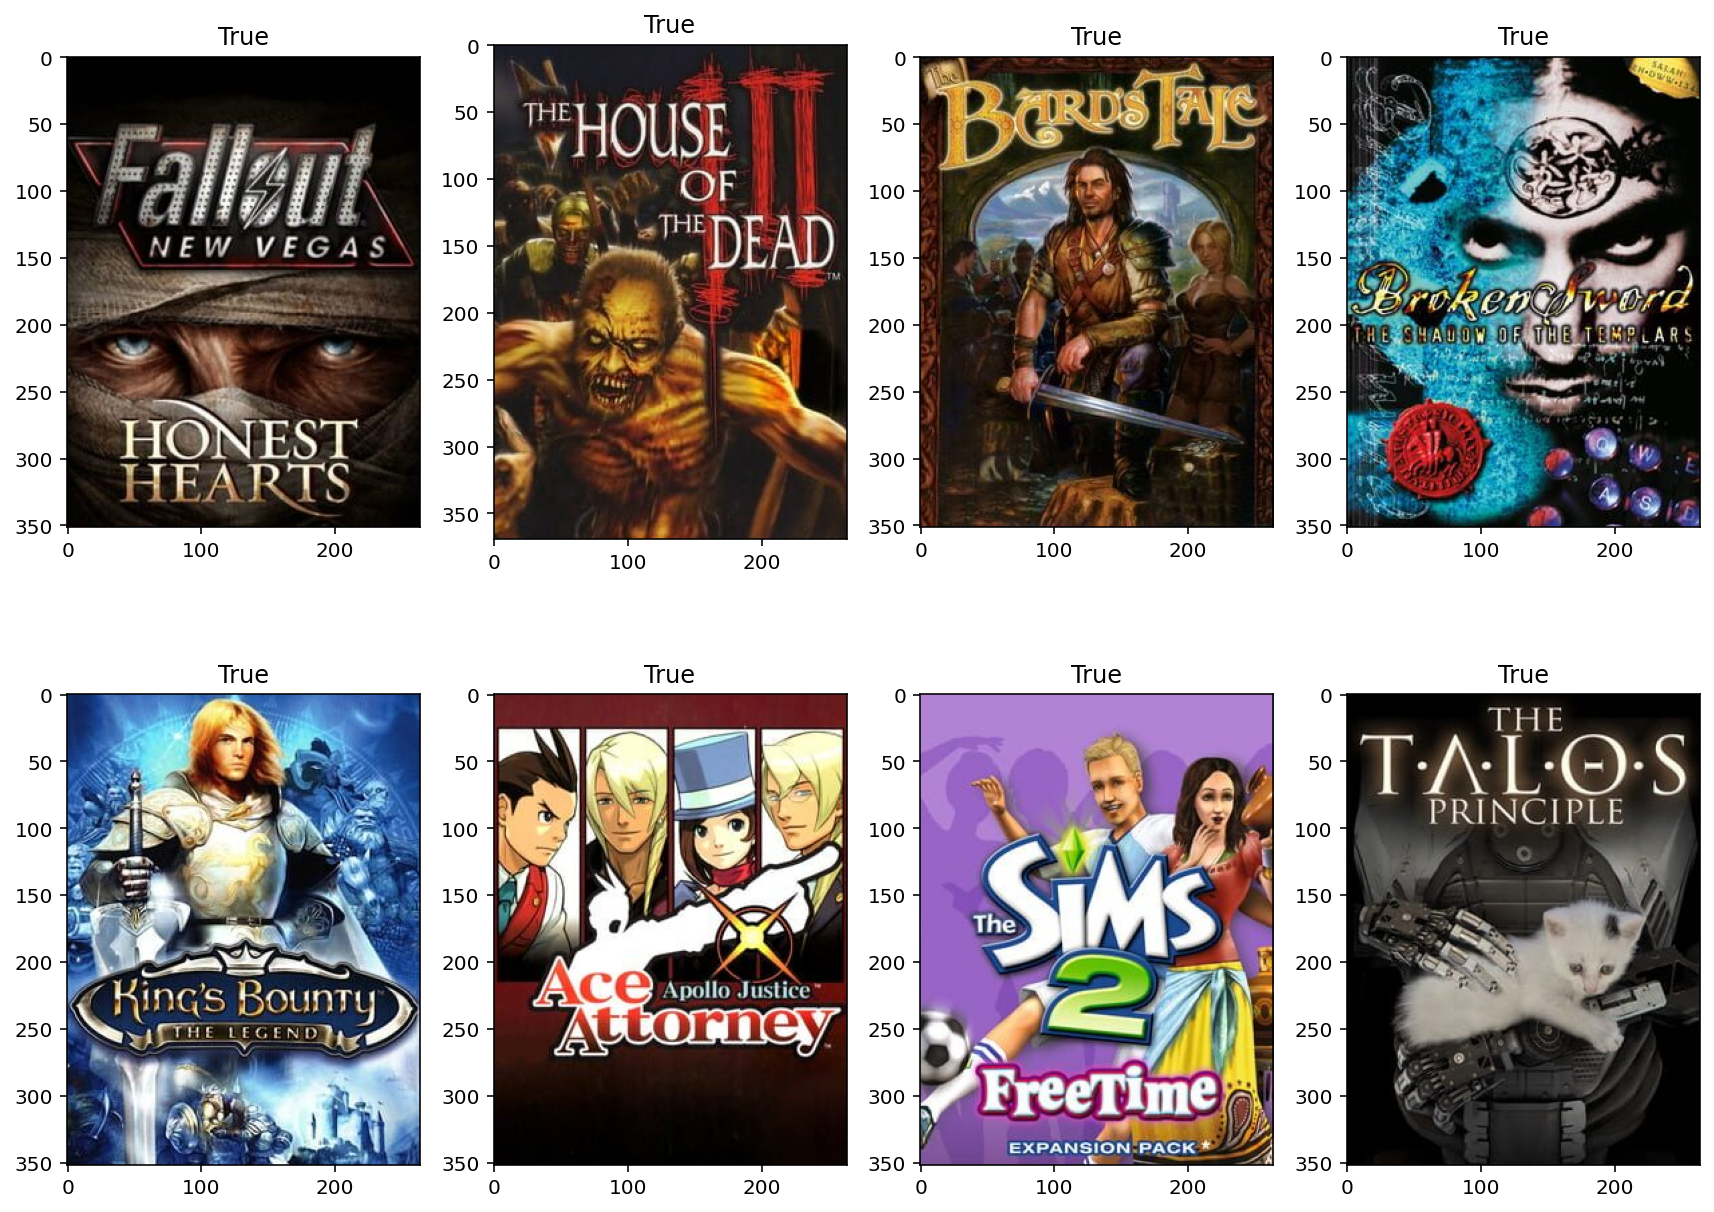

In [13]:
# review results manually: face detected
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize=(12, 9))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(mpimg.imread(im_dir + sample[sample.face == True].iloc[i,0]))
    ax.set_title(str(sample[sample.face == True].iloc[i,1]))
plt.tight_layout()

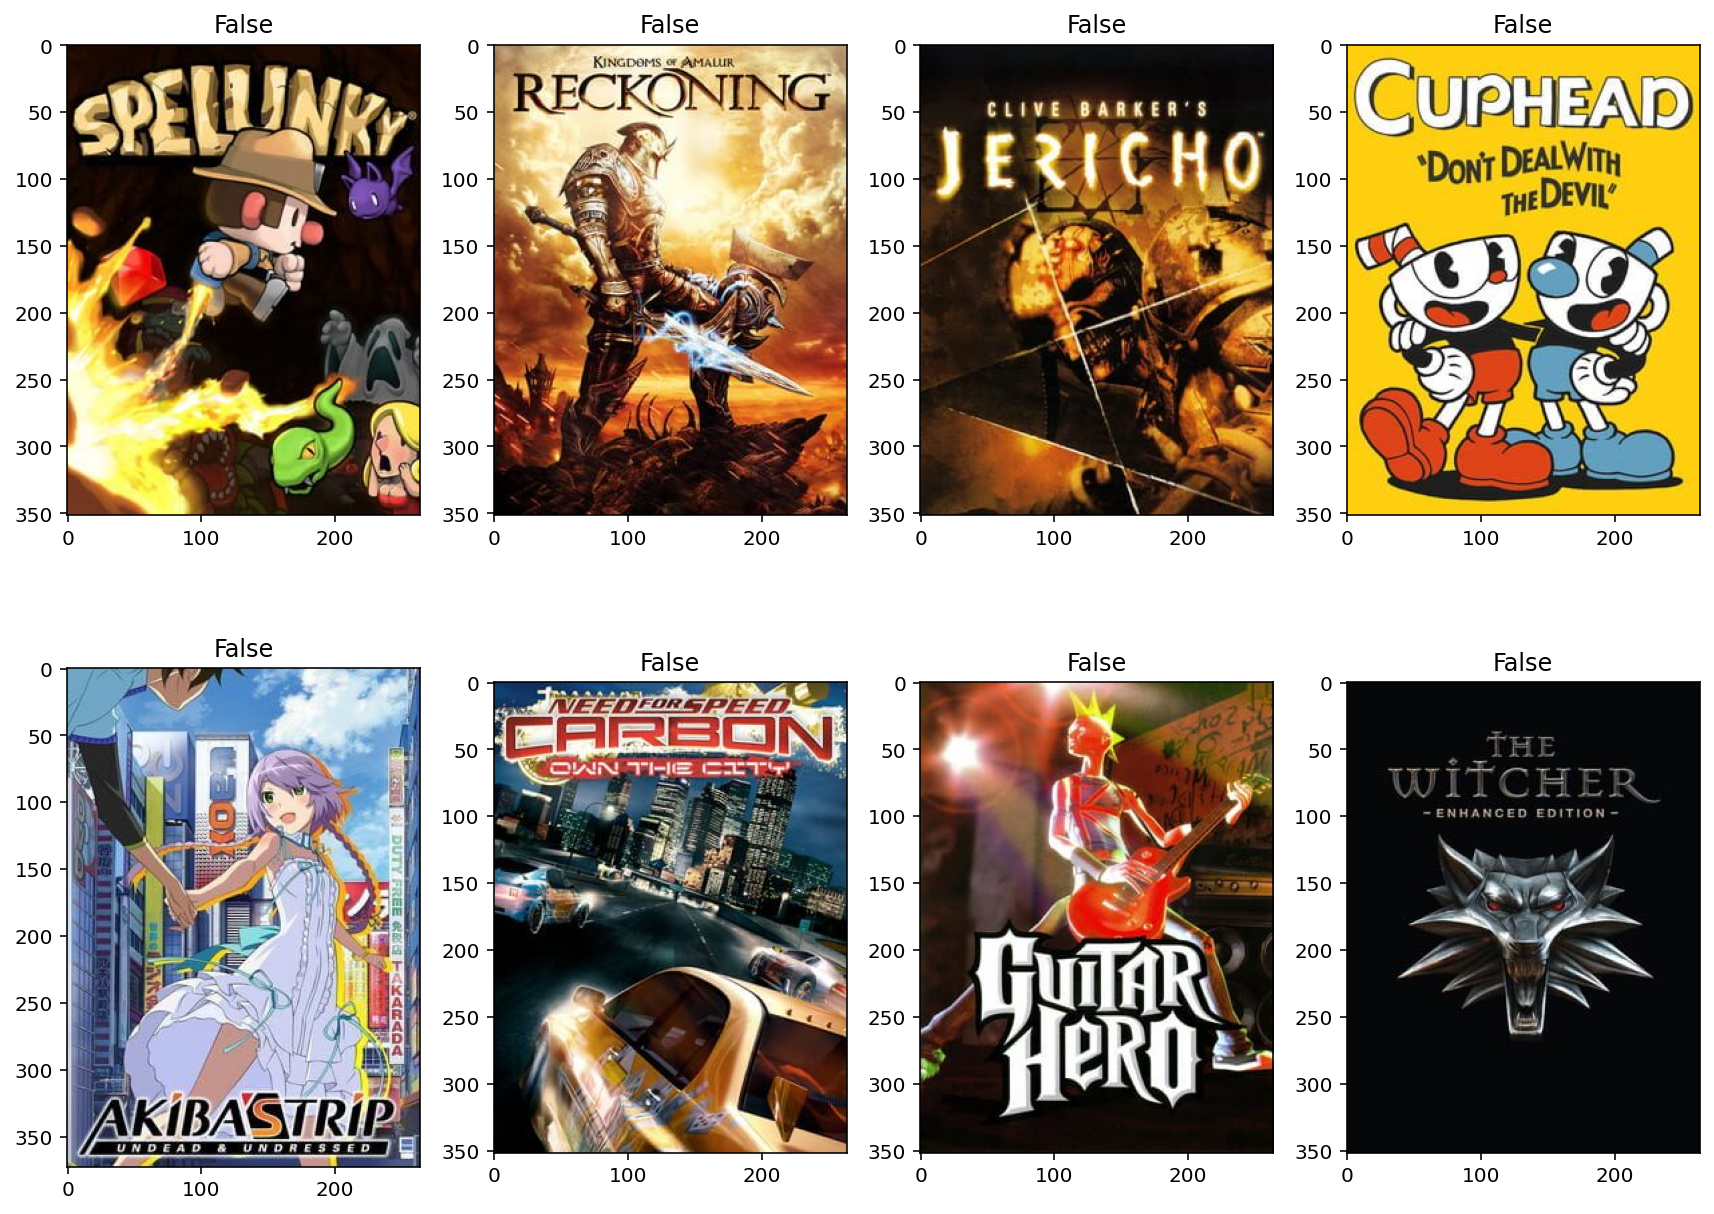

In [14]:
# review results manually: no face detected
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize=(12, 9))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(mpimg.imread(im_dir + sample[sample.face == False].iloc[i,0]))
    ax.set_title(str(sample[sample.face == False].iloc[i,1]))
plt.tight_layout()

In [15]:
games_df = pd.read_csv('data/games.csv')

In [16]:
face_df['id'] = face_df.path.apply(lambda x: x.split('.')[0])
face_df['id'] = face_df.id.astype('int64')

results = face_df.merge(games_df, how = 'left', on = 'id')
results.to_csv('output/features/face_detection_results.csv')

In [17]:
results['binary'] = results.rating > 3

results.binary = results.binary.replace(True, 'Above 16')
results.binary = results.binary.replace(False, 'Under 16')

In [18]:
results.head()

path   face     id                                              cover  \
0      1.jpg  False      1  //images.igdb.com/igdb/image/upload/t_thumb/co...   
1    100.jpg  False    100  //images.igdb.com/igdb/image/upload/t_thumb/co...   
2   1000.jpg  False   1000  //images.igdb.com/igdb/image/upload/t_thumb/co...   
3   1001.jpg  False   1001  //images.igdb.com/igdb/image/upload/t_thumb/co...   
4  10017.jpg   True  10017  //images.igdb.com/igdb/image/upload/t_thumb/co...   

                        name  rating    binary  
0    Thief II: The Metal Age     4.0  Above 16  
1  Need for Speed: ProStreet     1.0  Under 16  
2    Oddworld: Abe's Exoddus     3.0  Under 16  
3  Oddworld: Munch's Oddysee     3.0  Under 16  
4               Babel Rising     2.0  Under 16

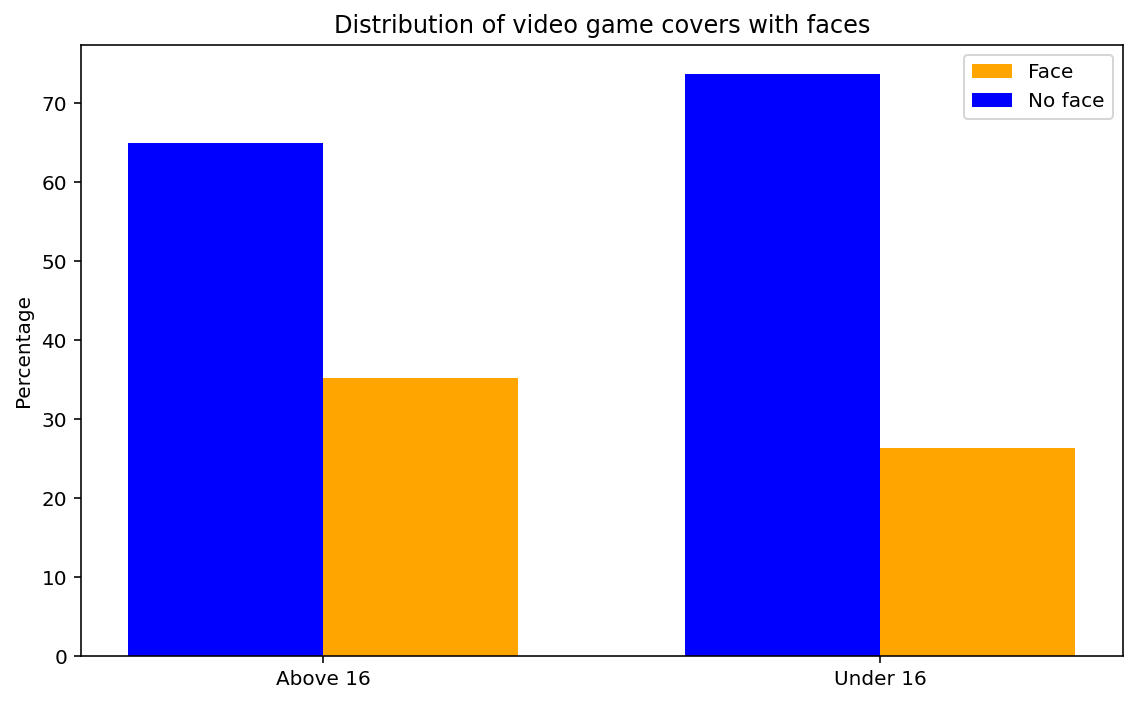

In [19]:
above_16 = len(results[results.binary == 'Above 16'])
under_16 = len(results[results.binary == 'Under 16'])

above16_true = len(results[(results.face == True) & (results.binary == 'Above 16')]) / above_16 * 100
above16_false = len(results[(results.face == False) & (results.binary == 'Above 16')]) / above_16 * 100
under16_true = len(results[(results.face == True) & (results.binary == 'Under 16')]) / under_16 * 100
under16_false = len(results[(results.face == False) & (results.binary == 'Under 16')]) / under_16 * 100

face_true_data = [above16_true, under16_true]
face_false_data = [above16_false, under16_false]

labels = ['Above 16','Under 16']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

rects1 = ax.bar(x + width / 2, face_true_data, width, label = 'Face', color = 'orange')
rects2 = ax.bar(x - width / 2, face_false_data, width, label = 'No face', color = 'blue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Distribution of video game covers with faces')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig('output/figures/face_distribution.png')
plt.show()

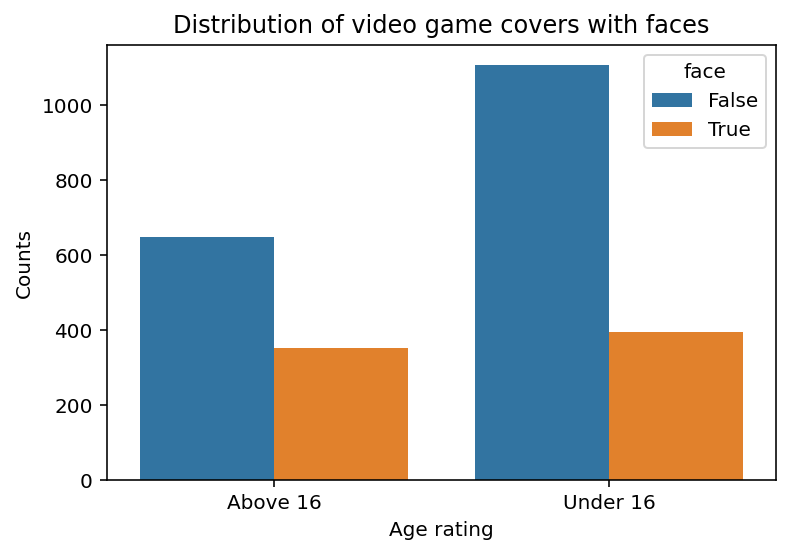

In [20]:
ax = sns.countplot(x = 'binary', hue = 'face', data = results)
_ = ax.set(xlabel = "Age rating", ylabel = "Counts")
_ = ax.set(title = 'Distribution of video game covers with faces')

In [21]:
# Check accuracy of face detection method on a sample of labelled images

# folders with labelled images
pos_dir = 'data/sample/face/'
neg_dir = 'data/sample/no_face/'
pos_paths = os.listdir(pos_dir)
neg_paths = os.listdir(neg_dir)

face_pos = []
face_neg = []

for p in pos_paths:
    res = face_detect(pos_dir + p)
    face_pos.append(res)

for p in neg_paths:
    res = face_detect(neg_dir + p)
    face_neg.append(res)

print('accuracy on covers containing faces: ', sum(face_pos) / len(face_pos))
print('accuracy on covers without faces: ', (len(face_neg) - sum(face_neg)) / len(face_neg))
print('total accuracy on sample: ', (sum(face_pos) + (len(face_neg) - sum(face_neg))) / (len(face_pos) + len(face_neg)))

accuracy on covers containing faces:  0.7692307692307693
accuracy on covers without faces:  0.8
total accuracy on sample:  0.7948717948717948
